In [1]:
import pandas as pd
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

RANDOM_STATE = 74

In [2]:
# Load data

user_df = pd.read_csv('takehome_users.csv', encoding='latin1', parse_dates=['creation_time'])
engagement_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'], index_col='time_stamp')

# Data Cleaning Exploration

In [3]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
user_df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [5]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [6]:
engagement_df.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [7]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  207917 non-null  int64
 1   visited  207917 non-null  int64
dtypes: int64(2)
memory usage: 4.8 MB


In [8]:
engagement_df.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


**Initial Observations**
- Takehome users data has missing values in `last_session_creation_time` and `invited_by_user_id`
- ID cols in both datasets need to be converted to `pd.Categorical`
- `creation_source` needs to be converted to `pd.Categorical`
- `last_session_creation_time` needs to be converted from a unix timestamp to datetime
- `opted_in_to_mailing_list` and `enabled_for_marketing_drip` are binary columns
- `visited` in engagements is a constant value, so it will be dropped.

In [9]:
# Percent of values missing in last session creation time

user_df['last_session_creation_time'].isna().sum() / len(user_df) * 100

26.474999999999998

Given this percentage of missing values, and the fact that we are trying to predict users who have logged into the product on three separate days, we'll go ahead and drop this column.

In [10]:
# Drop column

user_df = user_df.drop(labels=['last_session_creation_time'], axis=1)

In [11]:
# Percent of rows not invited by another user

user_df['invited_by_user_id'].isna().sum() / len(user_df) * 100

46.525

Since this column has such a high % of values missing and likely does not contribute to our analysis, we'll use it to create a new feature `invited` then drop it. This will store a 1 if the user was invited by another user, and 0 otherwise.

In [12]:
# Create new feature and drop old one

user_df['invited'] = user_df['invited_by_user_id'].notnull().astype('int')
user_df = user_df.drop(['invited_by_user_id'], axis=1)

In [13]:
# Convert categorical columns

user_df['org_id'] = pd.Categorical(values=user_df['org_id'], ordered=False)
user_df['creation_source'] = pd.Categorical(
    values=user_df['creation_source'], 
    categories=['PERSONAL_PROJECTS', 'GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH'], 
    ordered=False)
engagement_df['user_id'] = pd.Categorical(values=engagement_df['user_id'], ordered=False)

In [14]:
# Drop constant column

engagement_df = engagement_df.drop(labels=['visited'], axis=1)
engagement_df.columns

Index(['user_id'], dtype='object')

In [15]:
# Verify no missing values

assert user_df.isna().sum().all() == 0
assert engagement_df.isna().sum().all() == 0

In [16]:
engagement_df.index.is_monotonic_increasing or engagement_df.index.is_monotonic_decreasing

False

In [17]:
# Define method to check whether user is adopted or not

def is_adopted(id: int):
    if len(engagement_df[engagement_df['user_id'] == id]) < 3:
        return False
    else:
        user = engagement_df[engagement_df['user_id'] == id]
        return user.rolling(3).apply(lambda x: (x.index[-1] - x.index[0]).days <= 7).any()[0]

In [18]:
# Create adopted feature

user_df['adopted'] = user_df['object_id'].apply(is_adopted)
user_df.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,1,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,1,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,1,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,1,False


In [19]:
# Make user_id index

user_df = user_df.set_index(keys='object_id', drop=True)

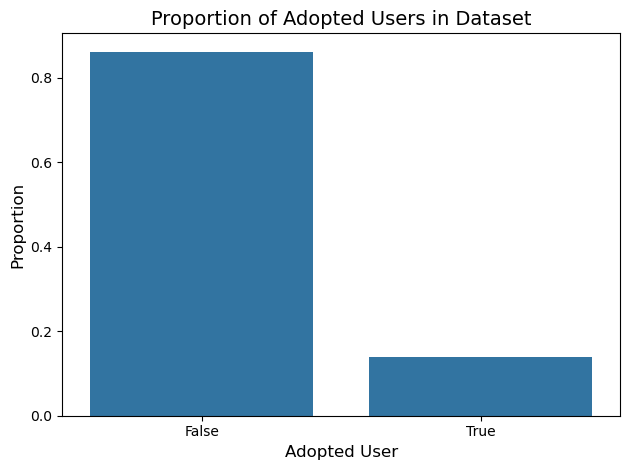

In [20]:
# Visualize proportion of adopted users in dataset

sns.countplot(
    data=user_df,
    x='adopted',
    stat="proportion"
)

plt.xlabel('Adopted User', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Proportion of Adopted Users in Dataset', fontsize=14)

plt.tight_layout()
plt.show()

In [21]:
user_id = user_df.index
creation_time_df = user_df.set_index(keys='creation_time')
creation_time_df['user_id'] = user_id
creation_time_df = creation_time_df.sort_index()

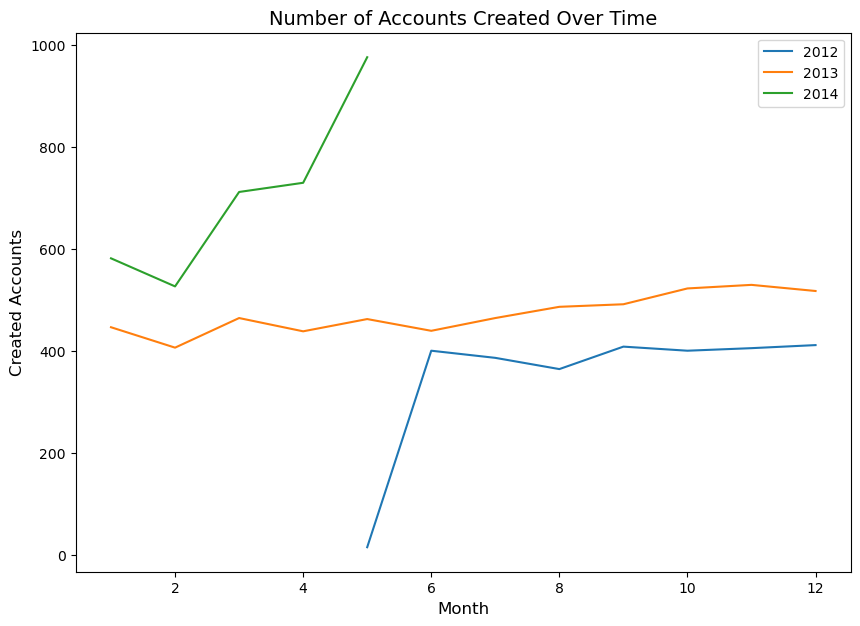

In [22]:
# Plot number of accounts created over time

creation_time_df['creation_date'] = creation_time_df.index.date
creation_time_df['month'] = creation_time_df.index.month
creation_time_df['year'] = creation_time_df.index.year

fig, ax = plt.subplots(figsize=(10, 7))

for year in creation_time_df['year'].unique():
    year_data = creation_time_df[creation_time_df['year'] == year]
    user_counts = year_data.groupby(by='month').size()
    ax.plot(user_counts.index, user_counts.values, label=year)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Created Accounts', fontsize=12)
plt.title('Number of Accounts Created Over Time', fontsize=14)
plt.legend()

plt.show()

Looks like signups grew steeply in the first year in about a month, gradually increased until February of 2014 then drastically increased. Let's see if anything is different about this time period.

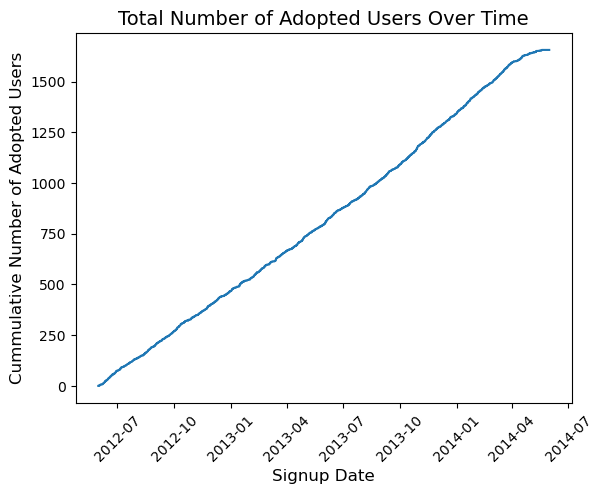

In [23]:
# Visualize adopted users over time

creation_time_df['cummulative_adopted'] = creation_time_df['adopted'].astype('int').cumsum()

plt.plot(creation_time_df.index, creation_time_df['cummulative_adopted'])
plt.xlabel('Signup Date', fontsize=12)
plt.ylabel('Cummulative Number of Adopted Users', fontsize=12)
plt.title('Total Number of Adopted Users Over Time', fontsize=14)

plt.xticks(rotation=45)
plt.show()

Looks like despite the drastic increase in signups after February of 2014, the number of adopted users increased linearly with a slight plateau at the end.

In [24]:
# Contingency table between creation source and adopted

ct = pd.crosstab(user_df['creation_source'], user_df['adopted'], normalize='index').iloc[:, ::-1]
print(ct)

adopted                True      False
creation_source                       
PERSONAL_PROJECTS   0.081478  0.918522
GUEST_INVITE        0.170596  0.829404
ORG_INVITE          0.134932  0.865068
SIGNUP              0.144705  0.855295
SIGNUP_GOOGLE_AUTH  0.172563  0.827437


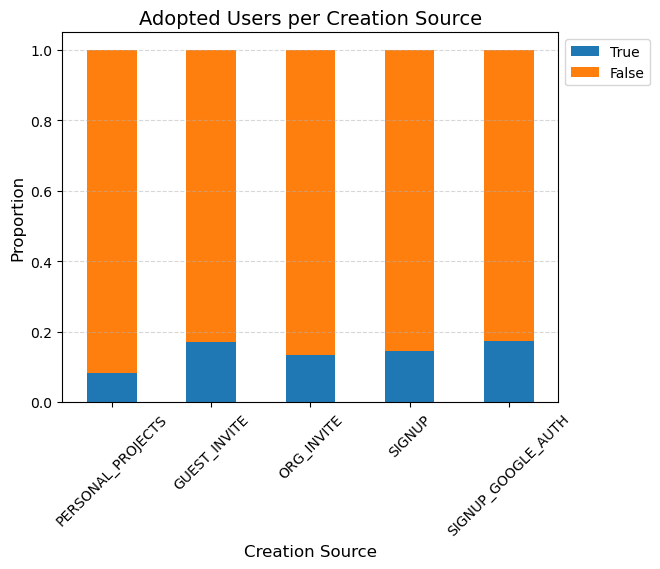

In [25]:
# Visualize relationship between creation source and adopted users

ct.plot(kind='bar', stacked=True)

plt.legend(bbox_to_anchor=(1, 1))
plt.grid(axis='y', alpha=0.5, linestyle='--')

plt.xlabel('Creation Source', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Adopted Users per Creation Source', fontsize=14)
plt.xticks(rotation=45)

plt.show()

Looks like users who signed up through Google or were invited are the most likely to be adopted.

# Modeling

## Preprocessing

In [26]:
user_df.head()

,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,adopted
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,1,False
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,1,True
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1,False
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,1,False
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,1,False


In [27]:
# Convert bool to 0s and 1s
user_df['adopted'] = user_df['adopted'].astype('int')

# Convert category to dummies
creation_dummies = pd.get_dummies(data=user_df['creation_source'], drop_first=True)
user_df = pd.concat([user_df, creation_dummies], axis=1)

# Extract features from datetime
user_df['year'] = user_df['creation_time'].dt.year
user_df['month'] = user_df['creation_time'].dt.month
user_df['day'] = user_df['creation_time'].dt.day

# Drop unecessary or redundant columns
cols_to_drop = ['name', 'email', 'creation_source', 'creation_time']
user_df = user_df.drop(cols_to_drop, axis=1)

In [28]:
# Check data types

user_df.dtypes

opted_in_to_mailing_list         int64
enabled_for_marketing_drip       int64
org_id                        category
invited                          int64
adopted                          int64
GUEST_INVITE                     uint8
ORG_INVITE                       uint8
SIGNUP                           uint8
SIGNUP_GOOGLE_AUTH               uint8
year                             int64
month                            int64
day                              int64
dtype: object

In [29]:
# Prepare training and test splits
X = user_df.drop(labels='adopted', axis=1)
y = user_df['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Prepare k folds
kf = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)

## Modeling

### Random Forests

In [30]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

rf_cv = cross_val_score(estimator=rf, X=X_train, y=y_train, cv=kf)

print(f"Cross-validation scores: {rf_cv}")
print(f"Average cross-validation score: {rf_cv.mean()}")

Cross-validation scores: [0.84404762 0.85119048 0.84940476 0.84940476 0.84583333]
Average cross-validation score: 0.8479761904761904


### Gradient Boosting

In [31]:
gbc = GradientBoostingClassifier(random_state=RANDOM_STATE)

gbc_cv = cross_val_score(estimator=gbc, X=X_train, y=y_train, cv=kf)

print(f"Cross-validation scores: {gbc_cv}")
print(f"Average cross-validation score: {gbc_cv.mean()}")

Cross-validation scores: [0.86190476 0.86309524 0.8625     0.8625     0.86190476]
Average cross-validation score: 0.8623809523809524


The *gradient boosting classifier* performed better than the *random forests* model, scoring an average 86% accuracy on the training data.

In [32]:
# Score models on test data

models = {
    'random forest': rf,
    'gradient boosting': gbc
}
rf.score
for model_name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)

    print(f"{model_name} score: {accuracy}")

random forest score: 0.8488888888888889
gradient boosting score: 0.86


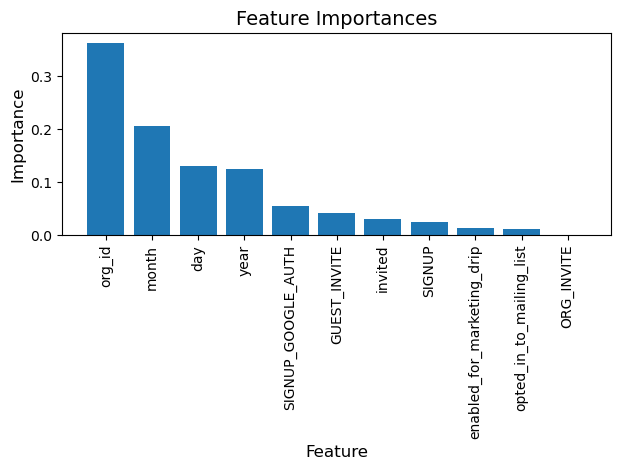

In [41]:
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': gbc.feature_importances_}).sort_values(by='Importance', ascending=False)

plt.bar(importance_df['Feature'], importance_df['Importance'])

plt.ylabel('Importance', fontsize=12)
plt.xlabel('Feature', fontsize=12)
plt.title('Feature Importances', fontsize=14)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Based on the feature importances determined by our gradient boosting classifier, `org_id`, `creation_date`, and `creation_source` are top predictors of future user adoption. The impact of creation source was verified earlier as well.